# Accesso a Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Descarga del dataset

In [2]:
# Instalar kaggle para tener acceso mediante API KEY
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/chest-xray-classification/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Descarga del dataset Chest X-Ray Images (Pneumonia)
# link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

100% 2.29G/2.29G [00:25<00:00, 136MB/s]
100% 2.29G/2.29G [00:25<00:00, 96.2MB/s]


In [4]:
# Eliminado de ficheros y carpetas innecesarias
!rm chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX/
!rm -rf chest_xray/chest_xray/
# La carpeta 'val' solo tiene 16 imágenes por lo que las pasamos al conjunto de 'train'
!cp -a chest_xray/val/NORMAL/. chest_xray/train/NORMAL/
!cp -a chest_xray/val/PNEUMONIA/. chest_xray/train/PNEUMONIA/
!rm -rf chest_xray/val/

# Importar las librerías

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

sns.set()

# Construir el modelo CNN

In [6]:
target_size = (256, 256)
batch_size = 32
train_directory = "chest_xray/train"
test_directory = "chest_xray/test"

In [7]:
def model_builder():
    classifier = Sequential()
    classifier.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          input_shape=(*target_size, 3),
                          activation="relu"))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Conv2D(filters=64,
                          kernel_size=(3, 3),
                          activation="relu"))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(units=128, activation="relu"))
    classifier.add(Dropout(rate=0.2))
    classifier.add(Dense(units=1, activation="sigmoid"))
    classifier.compile(optimizer="adam",
                       loss="binary_crossentropy",
                       metrics=["accuracy"])
    return classifier

In [8]:
classifier = model_builder()

# Ajustar la CNN a las imágenes para entrenar

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

training_dataset = train_datagen.flow_from_directory(
    directory=train_directory,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
    )

validation_dataset = train_datagen.flow_from_directory(
    directory=train_directory,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
    )

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [10]:
train_images, train_labels = next(training_dataset)
label_names = {
    0: "Normal",
    1: "Pneumonia"
}

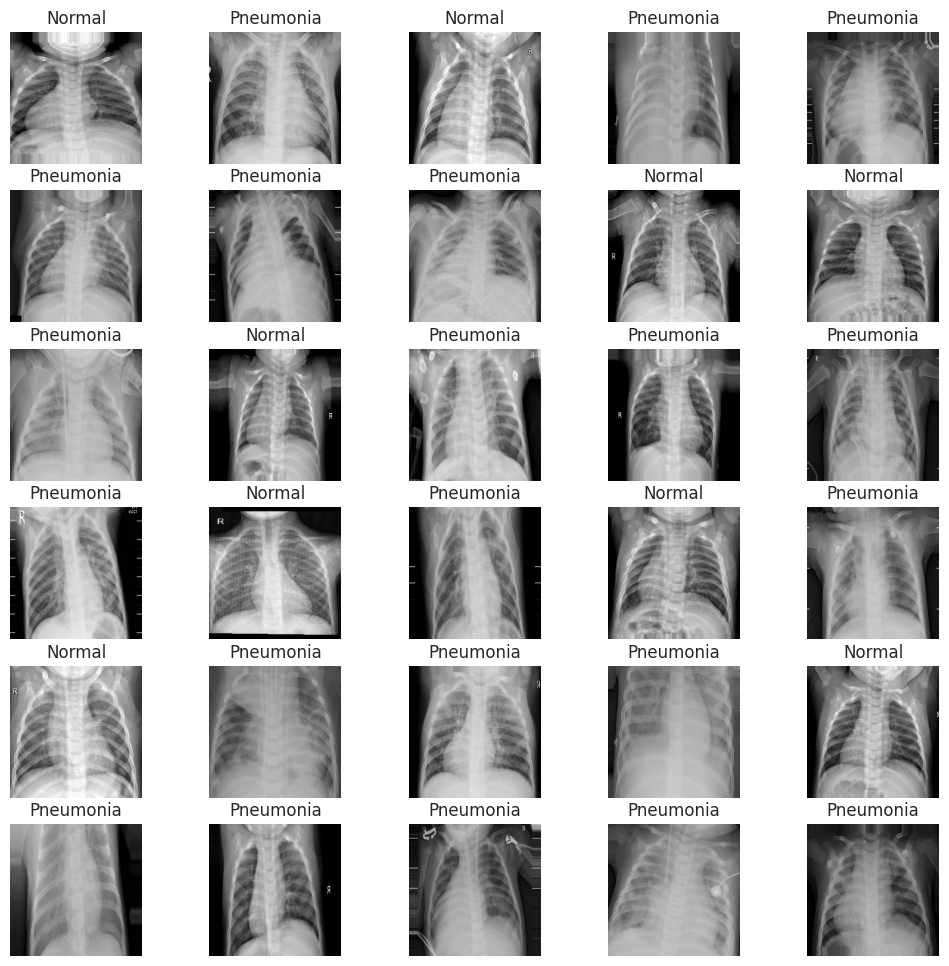

In [11]:
# Crear una matriz de 30 imágenes junto con sus etiquetas correspondientes
L = 6
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[train_labels[i]])
    axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)

In [12]:
modelpath = "/content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5"
checkpoint = ModelCheckpoint(filepath=modelpath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

In [ ]:
history = classifier.fit(
    training_dataset,
    steps_per_epoch=training_dataset.n//batch_size,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.n//batch_size,
    callbacks=[checkpoint]
    )

Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.8493
Epoch 1: val_loss improved from inf to 0.25554, saving model to /content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 157s 1s/step - loss: 0.5562 - accuracy: 0.8493 - val_loss: 0.2555 - val_accuracy: 0.8877
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 0.2316 - accuracy: 0.9085
Epoch 2: val_loss did not improve from 0.25554
130/130 [==============================] - 138s 1s/step - loss: 0.2316 - accuracy: 0.9085 - val_loss: 0.3025 - val_accuracy: 0.8711
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.9172
Epoch 3: val_loss improved from 0.25554 to 0.21958, saving model to /content/drive/MyDrive/chest-xray-classification/checkpoint/mymodel.hdf5
130/130 [==============================] - 126s 971ms/step - loss: 0.2068 - accuracy: 0.9172 - val_loss: 0.2196 - val_accuracy: 0.9121
Epoch 4/100
130/130 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.9223
Epoch 4: val_loss did not improve from 0.21958
130/130 [==============================] - 142s 1s/step - loss: 0.1924 - ac

# Visualizar evolución del loss y accuracy a lo largo de las epochs

In [ ]:
def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title("Model "+ title)
    ax.set_ylabel(title)
    ax.set_xlabel("Epochs")
    ax.legend(["Training", "Validation"])

plt.subplots(figsize=(8, 8))
plt.tight_layout()
display_training_curves(history.history["accuracy"], history.history["val_accuracy"], "Accuracy", 211)
display_training_curves(history.history["loss"], history.history["val_loss"], "Loss", 212)
plt.subplots_adjust(hspace=0.3)
plt.show()

# Predicciones sobre el conjunto de test

In [13]:
model = load_model(filepath=modelpath)

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
testing_dataset = test_datagen.flow_from_directory(
    directory=test_directory,
    shuffle=True,
    target_size=target_size,
    batch_size=batch_size,
    class_mode="binary"
    )

evaluate = model.evaluate(testing_dataset, steps=testing_dataset.n//batch_size, verbose=1)

print("Precisión en el conjunto de test: {}".format(evaluate[1]))

Found 624 images belonging to 2 classes.
19/19 [==============================] - 27s 1s/step - loss: 0.3391 - accuracy: 0.9128
Precisión en el conjunto de test: 0.9128289222717285


In [15]:
prediction = []
original = []
image = []
threshold = 0.5

for label in training_dataset.class_indices:
    folder_path = os.path.join(test_directory, label)
    for item in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = int(predict > threshold)
        prediction.append(predict)
        original.append(training_dataset.class_indices[label])

1/1 [==============================] - 0s 62ms/step


In [16]:
score = accuracy_score(original, prediction)
print("Eficacia de la predicción: {}".format(score.round(4)))

Eficacia de la predicción: 0.9103


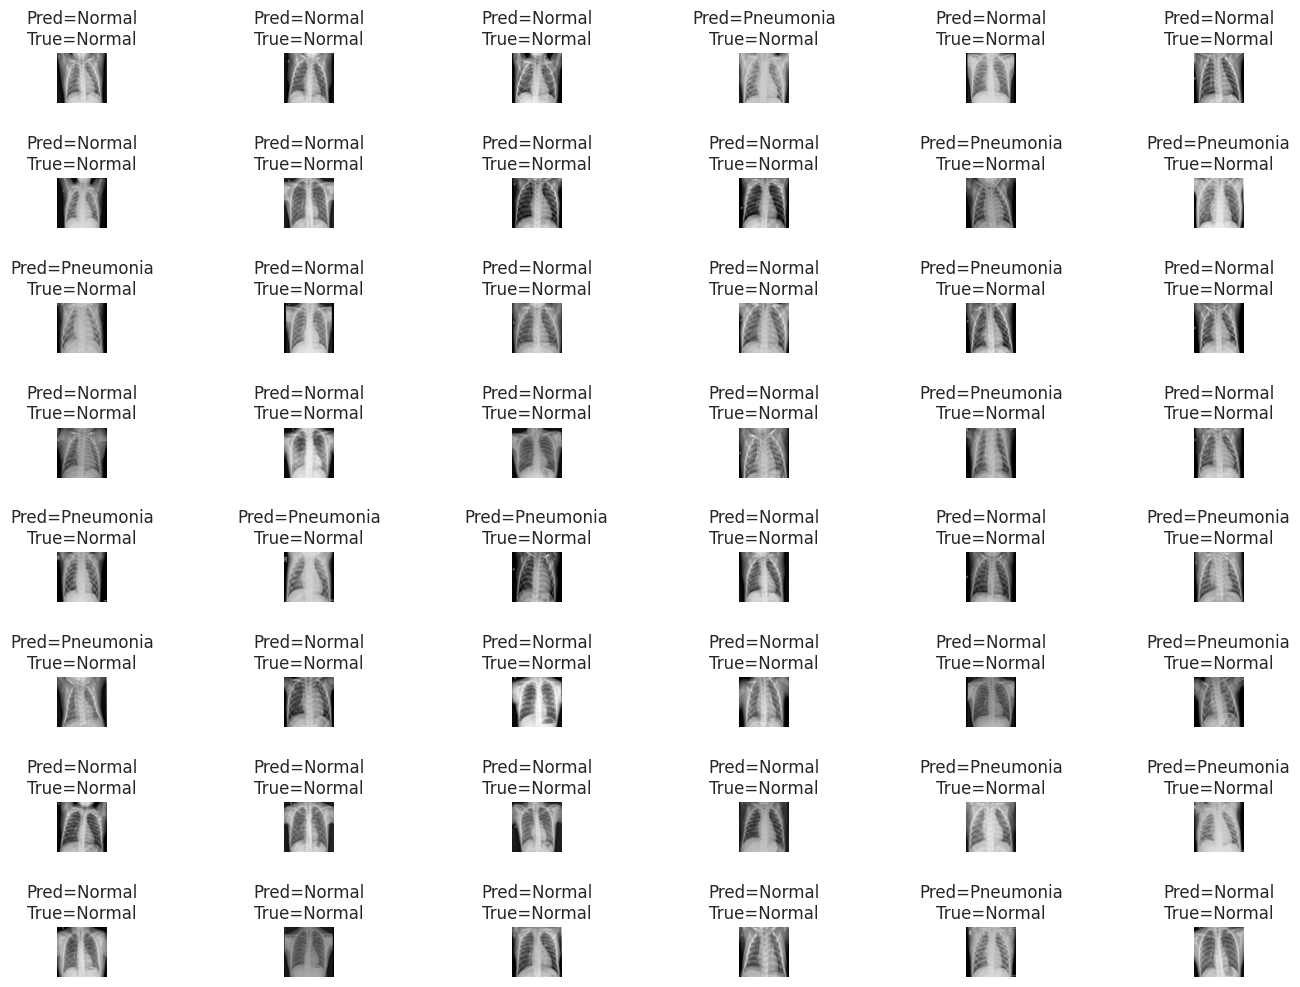

In [17]:
L = 8
W = 6

fig, axes = plt.subplots(L, W, figsize=(16, 12))
axes = axes.ravel()

for i in np.arange(L*W):
    axes[i].imshow(image[i])
    pred_label = label_names[prediction[i]]
    true_label = label_names[original[i]]
    axes[i].set_title("Pred={}\nTrue={}".format(pred_label, true_label))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1.2, hspace=1.5)

# Matriz de Confusión

In [18]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       234
           1       0.91      0.95      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



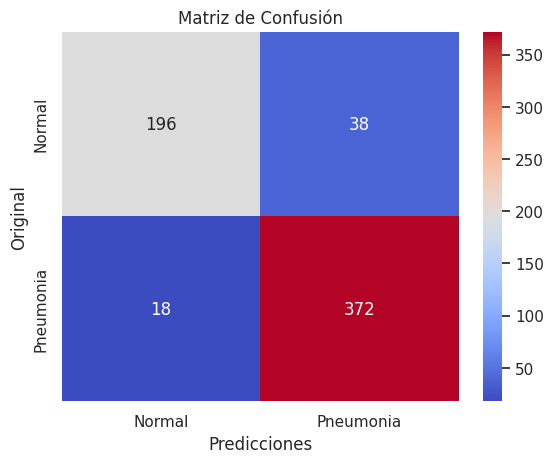

In [19]:
cm = confusion_matrix(original, prediction)
ax = plt.subplot()

sns.heatmap(cm, annot=True, ax=ax, fmt=".0f", cmap="coolwarm")
ax.set_xticklabels(list(label_names.values()))
ax.set_yticklabels(list(label_names.values()))
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusión")
plt.show()

# Curva ROC

In [20]:
fpr, tpr, _ = roc_curve(original, prediction)
auc_score = roc_auc_score(original, prediction).round(4)

print("AUC: ", auc_score)

AUC:  0.8957


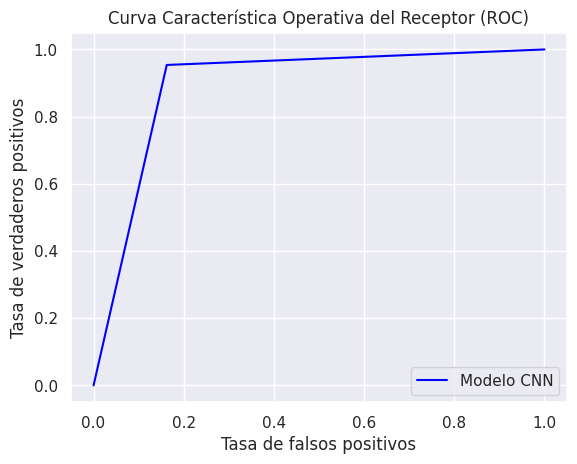

In [21]:
plt.plot(fpr, tpr, linestyle="-", color="blue", label="Modelo CNN")

plt.title("Curva Característica Operativa del Receptor (ROC)")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend(loc="best")
plt.show()